In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
import tqdm

In [2]:
# Robust Estimation of means:
# Huber weight function

def Huber(ei, sigma, s, a = 1.345):
    w1 = 1/sigma ** 2
    w2 = 1/sigma ** 2 * (a / (np.abs(ei) / (sigma * s)))
    weights = np.where(np.abs(ei) <= a * sigma * s, w1, w2)
    return weights

# For robust estimation of mean:

def ZL_robust_mean(y_, dy_, max_iter=50, tol=1e-6):
    """Output:
    robust mean,
    s (a sqrt(reduced chi2-like scale factor), s^2 ~ reduced chi2)"""
    y = y_
    dy = dy_
    y_bar = np.average(y, weights=1/dy**2)
    s = 1.0
    for _ in range(max_iter):
        ei = y - y_bar
        w = Huber(ei, dy, s)
        y_bar_old = y_bar
        y_bar = np.sum(w * y) / np.sum(w)
        mad = np.median(np.abs(y - y_bar) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0
        # tolerance check   
        if np.abs(y_bar - y_bar_old) < tol * (np.abs(y_bar_old) + 1e-12):
            break
    return y_bar, s

def bootstrap_ZL_robust_mean(y, dy, n_boot=5000, random_state=None):
    """Output:
    mean of bootstrap samples,
    std of bootstrap samples,
    all bootstrap samples
    """
    rng = np.random.default_rng(random_state)
    boot_means = np.empty(n_boot)
    n = len(y)
    for i in tqdm.tqdm(range(n_boot)):
        indices = rng.integers(0, n, n)
        y_sample = y[indices]
        dy_sample = dy[indices]
        boot_means[i] = ZL_robust_mean(y_sample, dy_sample)[0]
    return boot_means.mean(), boot_means.std(), boot_means

# Code for robust linear regression using IRLS and Huber weights

def irls_robust_linear(x, y, dy, max_iter=50, tol=1e-6):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    dy = np.asarray(dy, dtype=float)

    # Design matrix: y = a + b x
    A = np.vstack([np.ones_like(x), x]).T

    # Initial conditions
    n = len(y)
    s = 1.0
    w = np.ones(n) / dy**2

    def solve_wls(A, y, weights):
        W = np.sqrt(weights)
        Aw = A * W[:, None]
        yw = y * W
        theta, *_ = np.linalg.lstsq(Aw, yw, rcond=None)
        return theta

    # Initial least squares solution
    theta = solve_wls(A, y, w)

    for _ in range(max_iter):
        theta_old = theta.copy()
        s_old = s

        # 1. compute residuals
        y_fit = A @ theta
        r = y - y_fit

        # 2. update scale s using MAD of |r| / dy
        mad = np.median(np.abs(r) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0

        # 3. update weights using YOUR huber function
        w = Huber(r, dy, s)

        # 4. solve weighted least squares
        theta = solve_wls(A, y, w)

        # 5. convergence test
        if np.linalg.norm(theta - theta_old) < tol * (np.linalg.norm(theta_old) + 1e-12) and \
           abs(s - s_old) < tol * (s_old + 1e-12):
            break
    beta0, beta1 = theta
    return beta0, beta1, s, w

def bootstrap_irls(x, y, dy, n_boot=10000, random_state=None):
    """
    Bootstrap IRLS over (x, y, dy) triplets.
    
    Returns:
        beta0_samples : array of intercepts
        beta1_samples : array of slopes
        s_samples : array of scale estimates
    """
    import numpy as np

    if random_state is not None:
        np.random.seed(random_state)

    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    n = len(x)

    beta0_samples = np.empty(n_boot)
    beta1_samples = np.empty(n_boot)
    s_samples = np.empty(n_boot)

    for i in tqdm.tqdm(range(n_boot)):
        # 1. Resample indices with replacement
        idx = np.random.randint(0, n, size=n)

        # 2. Resample triplets together
        xb = x[idx]
        yb = y[idx]
        dyb = dy[idx]

        # 3. Run IRLS on bootstrap sample
        beta0, beta1, s, _ = irls_robust_linear(xb, yb, dyb)

        # 4. Store results
        beta0_samples[i] = beta0
        beta1_samples[i] = beta1
        s_samples[i] = s

    return beta0_samples, beta1_samples, s_samples

In [3]:
def make_plot(df, x_name, y_name, dy_name, x_unit, ax, row, col):

    x = df[x_name]
    y = df[y_name]
    dy = df[dy_name]

    beta0 , beta1, s, w= irls_robust_linear(x, y, dy)
    w = w / np.max(w)  # normalize weights for plotting
    beta0_samples, beta1_samples, s_samples = bootstrap_irls(x, y, dy, n_boot=5000, random_state=None)
    se_beta0 = np.std(beta0_samples)
    se_beta1 = np.std(beta1_samples)

    print(f"Intercept: {beta0 * 1000000:.2e} ± {se_beta0 * 1000000:.2e} μrad")
    print(f"Slope: {beta1 * 1000000:.2e} ± {se_beta1 * 1000000:.2e} μrad/"+f"{x_unit}")
    print(f"Scale s: {s:.4f}")


    # error bar plot with horizontal caps on error bar
    #ax.errorbar(x, y*1000000, yerr=dy*1000000, fmt='.', markersize = 0, capsize=3, label='Data with error bars')
    ax[row, col].scatter(x, y*1000000, s=100, marker = 's',c='blue', alpha=w*0.5, edgecolors= 'none')
    # plot best fit line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = beta0 + beta1 * x_fit
    ax[row, col].plot(x_fit, y_fit*1000000, 'r-', label='beta0 = {:.2e} ± {:.2e} μrad\nbeta1 = {:.2e} ± {:.2e} μrad/{}\n slope {:.1f} sigma'.format(
        beta0 * 1000000, se_beta0 * 1000000, beta1 * 1000000, se_beta1 * 1000000, x_unit, beta1 / se_beta1))
    ax[row, col].grid()
    ax[row, col].set_xlabel(f"{x_name} ({x_unit})", fontsize=14)
    ax[row, col].set_ylabel(f"{y_name} (μrad)", fontsize=14)
    ax[row, col].legend(loc = 'upper left')
    ax[row, col].set_title(y_name)

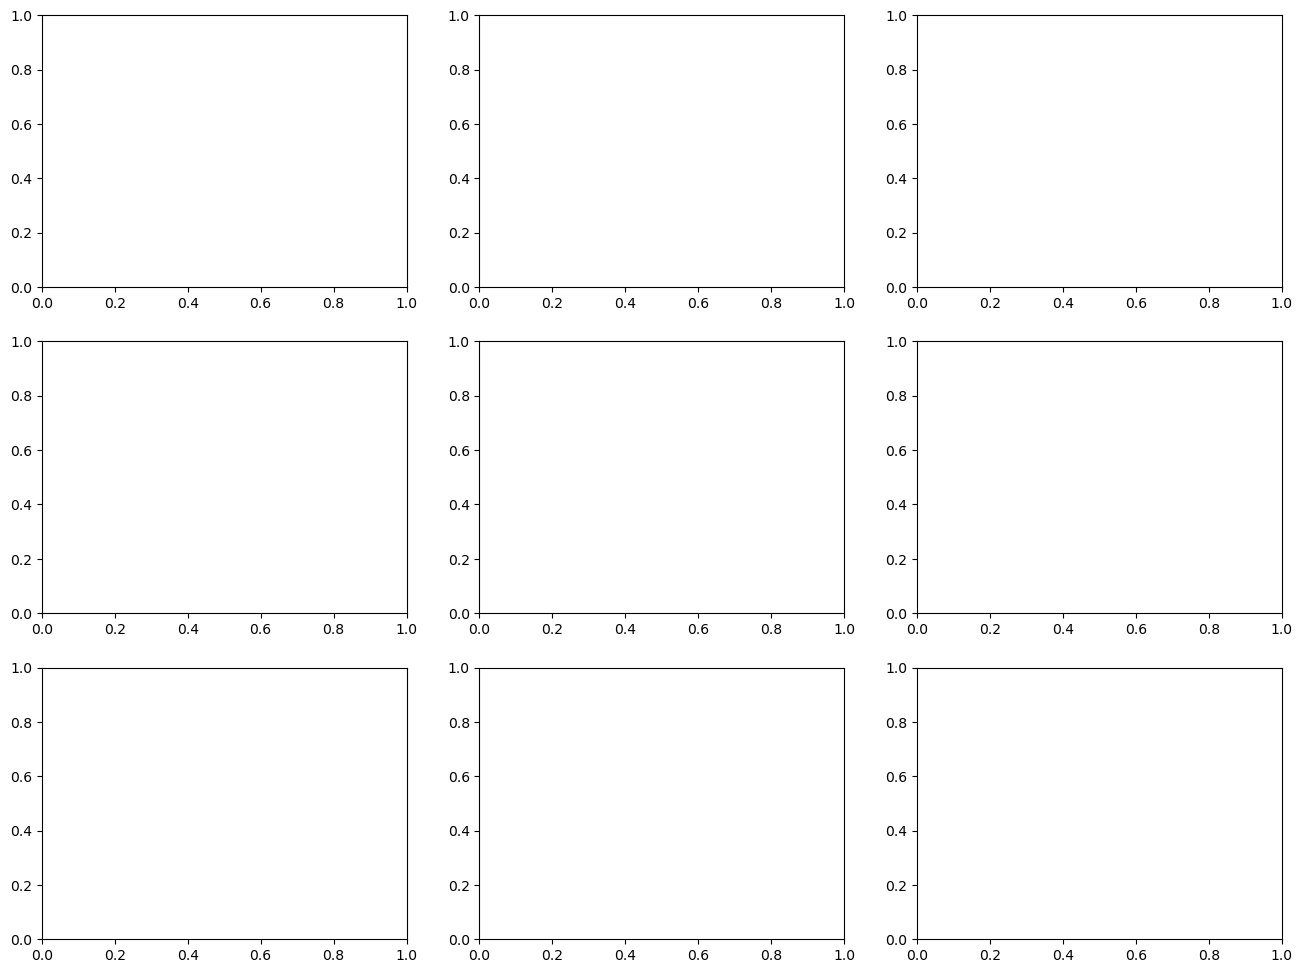

In [4]:

df = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.0799.csv")
fig_title = "No Prep - 1090 Ellip - Phase, 0016.0799"
df = df.dropna()
fig, ax = plt.subplots(3, 3, figsize=(16,12))

x_name = '1090_STIRAP_ellipticity_angle'
x_unit = 'deg'

In [5]:
# NE, E, NEB, NEC, EC, NEBC, NEPR, EPR, NEBPR
df["Ellipticity_NE"] = df["Am_NE"]/2
df["uncertainty_Ellipticity_NE"] = df["uncertainty_Am_NE"]/2
df["Ellipticity_E"] = df["Am_E"]/2
df["uncertainty_Ellipticity_E"] = df["uncertainty_Am_E"]/2
df["Ellipticity_NEB"] = df["Am_NEB"]/2
df["uncertainty_Ellipticity_NEB"] = df["uncertainty_Am_NEB"]/2
df["Ellipticity_NEC"] = df["Am_NEC"]/2
df["uncertainty_Ellipticity_NEC"] = df["uncertainty_Am_NEC"]/2
df["Ellipticity_EC"] = df["Am_EC"]/2
df["uncertainty_Ellipticity_EC"] = df["uncertainty_Am_EC"]/2
df["Ellipticity_NEBC"] = df["Am_NEBC"]/2
df["uncertainty_Ellipticity_NEBC"] = df["uncertainty_Am_NEBC"]/2
df["Ellipticity_NEPR"] = df["Am_NEPR"]/2
df["uncertainty_Ellipticity_NEPR"] = df["uncertainty_Am_NEPR"]/2
df["Ellipticity_EPR"] = df["Am_EPR"]/2
df["uncertainty_Ellipticity_EPR"] = df["uncertainty_Am_EPR"]/2
df["Ellipticity_NEBPR"] = df["Am_NEBPR"]/2
df["uncertainty_Ellipticity_NEBPR"] = df["uncertainty_Am_NEBPR"]/2

In [6]:

make_plot(df, x_name, "phi_NE" , "uncertainty_phi_NE", x_unit, ax, 0, 0)
make_plot(df, x_name, "phi_E" , "uncertainty_phi_E", x_unit, ax, 0, 1)
make_plot(df, x_name, "phi_NEB" , "uncertainty_phi_NEB", x_unit, ax, 0, 2)
make_plot(df, x_name, "phi_NEC" , "uncertainty_phi_NEC", x_unit, ax, 1, 0)
make_plot(df, x_name, "phi_EC" , "uncertainty_phi_EC", x_unit, ax, 1, 1)
make_plot(df, x_name, "phi_NEBC" , "uncertainty_phi_NEBC", x_unit, ax, 1, 2)
make_plot(df, x_name, "phi_NEPR" , "uncertainty_phi_NEPR", x_unit, ax, 2, 0)
make_plot(df, x_name, "phi_EPR" , "uncertainty_phi_EPR", x_unit, ax, 2, 1)
make_plot(df, x_name, "phi_NEBPR" , "uncertainty_phi_NEBPR", x_unit, ax, 2, 2)
"""
make_plot(df, x_name, "Ellipticity_NE" , "uncertainty_Ellipticity_NE", x_unit, ax, 0, 0)
make_plot(df, x_name, "Ellipticity_E" , "uncertainty_Ellipticity_E", x_unit, ax, 0, 1)
make_plot(df, x_name, "Ellipticity_NEB" , "uncertainty_Ellipticity_NEB", x_unit, ax, 0, 2)
make_plot(df, x_name, "Ellipticity_NEC" , "uncertainty_Ellipticity_NEC", x_unit, ax, 1, 0)
make_plot(df, x_name, "Ellipticity_EC" , "uncertainty_Ellipticity_EC", x_unit, ax, 1, 1)
make_plot(df, x_name, "Ellipticity_NEBC" , "uncertainty_Ellipticity_NEBC", x_unit, ax, 1, 2)
make_plot(df, x_name, "Ellipticity_NEPR" , "uncertainty_Ellipticity_NEPR", x_unit, ax, 2, 0)
make_plot(df, x_name, "Ellipticity_EPR" , "uncertainty_Ellipticity_EPR", x_unit, ax, 2, 1)
make_plot(df, x_name, "Ellipticity_NEBPR" , "uncertainty_Ellipticity_NEBPR", x_unit, ax, 2, 2)
"""

fig.suptitle(fig_title, fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ACME\AppData\Local\Temp\ipykernel_38376\3667577055.py:6: RuntimeWarning: divide by zero encountered in divide
  w2 = 1/sigma ** 2 * (a / (np.abs(ei) / (sigma * s)))
100%|██████████| 5000/5000 [00:02<00:00, 2265.46it/s]


Intercept: -3.75e+01 ± 1.40e+01 μrad
Slope: 7.15e+01 ± 1.37e+01 μrad/deg
Scale s: 1.5206


100%|██████████| 5000/5000 [00:02<00:00, 1692.92it/s]


Intercept: 8.59e+00 ± 4.94e+00 μrad
Slope: -5.07e+01 ± 9.14e+00 μrad/deg
Scale s: 0.6627


100%|██████████| 5000/5000 [00:01<00:00, 4916.85it/s]


Intercept: -3.18e+00 ± 2.75e+00 μrad
Slope: -9.03e-02 ± 3.07e-01 μrad/deg
Scale s: 0.4544


100%|██████████| 5000/5000 [00:03<00:00, 1501.71it/s]


Intercept: 9.21e+00 ± 3.89e+00 μrad
Slope: -6.13e-01 ± 3.36e-01 μrad/deg
Scale s: 0.4575


100%|██████████| 5000/5000 [00:02<00:00, 1699.03it/s]


Intercept: -1.47e+01 ± 4.18e+00 μrad
Slope: 1.18e+00 ± 3.60e-01 μrad/deg
Scale s: 0.0848


100%|██████████| 5000/5000 [00:02<00:00, 1683.62it/s]


Intercept: -3.22e+00 ± 8.06e+00 μrad
Slope: -1.73e-01 ± 8.50e-01 μrad/deg
Scale s: 1.3111


100%|██████████| 5000/5000 [00:02<00:00, 2219.51it/s]


Intercept: -3.16e+01 ± 7.81e+00 μrad
Slope: -5.28e+00 ± 1.17e+00 μrad/deg
Scale s: 0.1726


100%|██████████| 5000/5000 [00:01<00:00, 3255.86it/s]


Intercept: 3.36e+01 ± 9.50e+00 μrad
Slope: 5.88e-02 ± 6.28e-01 μrad/deg
Scale s: 0.3357


100%|██████████| 5000/5000 [00:02<00:00, 1732.95it/s]


Intercept: 1.44e+01 ± 6.71e+00 μrad
Slope: 9.16e-02 ± 7.54e-01 μrad/deg
Scale s: 1.0239


C:\Users\ACME\AppData\Local\Temp\ipykernel_38376\1228391254.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


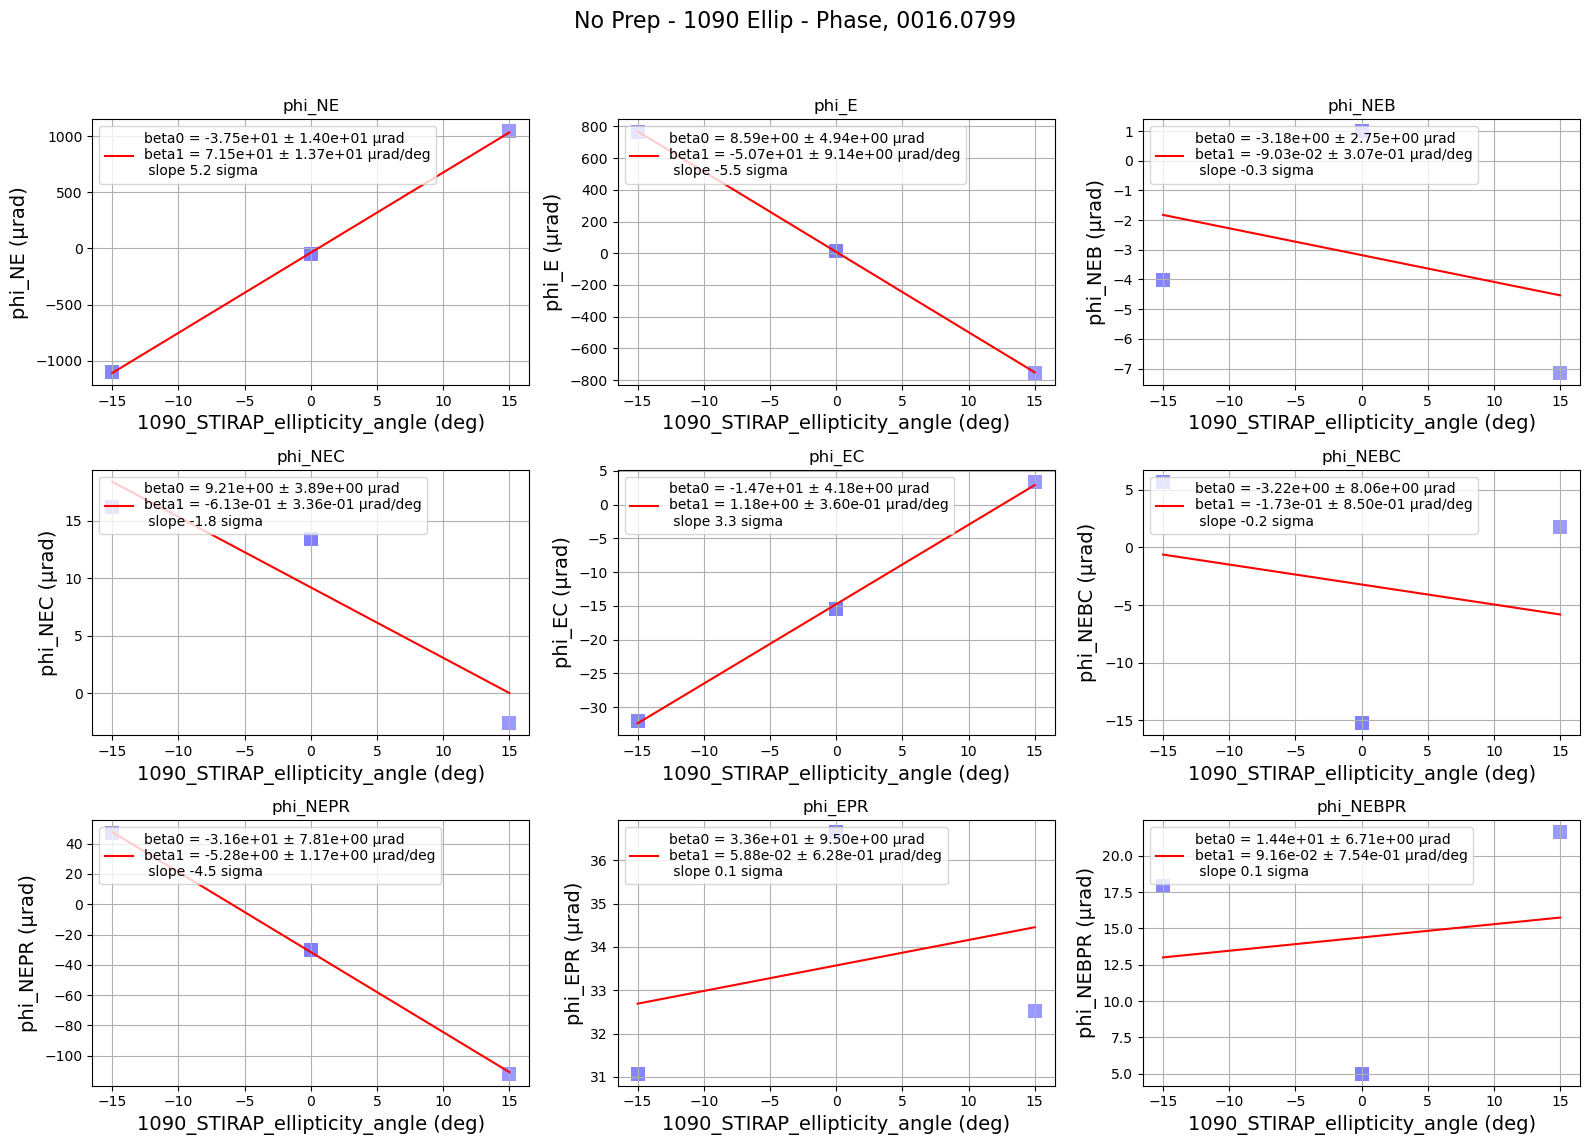

In [7]:
fig

In [8]:
fig.savefig(r"C:\ACMEcode\ACMEanalysis\notebooks\1090 Ellipticity\matrix\\" + fig_title + ".png")

In [15]:
inspect_channel = 'phi_E'
x_value = 15

df_slice = df[df[x_name] == x_value]

y = df_slice[inspect_channel]
dy = df_slice['uncertainty_' + inspect_channel]
y_mean, y_std, _ = bootstrap_ZL_robust_mean(y.values, dy.values)
print(f"For {inspect_channel} at {x_name} = {x_value} {x_unit}:")
print(f"Robust mean: {y_mean:.2e} ± {y_std:.2e} μrad")

100%|██████████| 5000/5000 [00:00<00:00, 13653.58it/s]

For phi_E at 1090_STIRAP_ellipticity_angle = 15 deg:
Robust mean: -7.55e-04 ± 0.00e+00 μrad
